In [54]:
import pandas as pd
import json

In [55]:
import spacy

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')

In [56]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words for various languages
nltk.download('stopwords')

# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')

print(spanish_stop_words)


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
spanish_stop_words.extend([
"mas",
"sino",
"esten",
"haber",
"hecho",
"si",
"cuya",
"siendo",
"hacen",
"unas",
"unos",
"sido",
"estan",
"ser",
"cuyo",
"hacer",
"poder",
"tener"
])

In [58]:

def load_json_from_path(file_path):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data



In [59]:
a1 = load_json_from_path('./data/article1.json')

In [60]:
a1

[{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
  'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
  'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
   '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
   '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
   'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores internacionales, pero la

In [40]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

In [43]:
documents = []
documents.extend(a1[0]['content'])
documents.extend(a1[1]['content'])
documents.extend(a1[2]['content'])

In [44]:
documents = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

In [45]:
documents

['explicacion narrativa petro red social crear segun colombia gobernado ano elite corrupto interesado solamente enriquecer perpetuar',
 'petro llegar primero presidente izquierda preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio',
 'narrativa simplista efectista danino comenzar problema petro exguerrillero presidente antonio navarro economia funcionar mejor polarizacion disparado mitad estancamiento pib obedecer factor internacional mitad tener nombre propio problema petro agitador politico brillante resultar administrador incompetente personalidad paranoico pendenciero habito trabajo extrano',
 'exito basar diagnostico acertado falla sistema embargo solucion siempre enmarcada optica lucha clase realista obsoleto petro tener frente sector privado prevencion cuasi marxista creer capitalismo fracasar tener razon aclarar socialismo fracasar',
 'oposicion oligarquia razon cambio pedir pueblo bloqueado planteamiento taquillero siemp

In [47]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Fit and transform the documents
X = vectorizer.fit_transform(documents)


In [208]:
#vectorizer.get_feature_names_out()

In [48]:
def generate_pairs(text):
    words = text.split()
    pairs = []
    for i in range(len(words) - 1):
        pairs.append(words[i]+" "+words[i+1])
    return pairs

In [49]:
docs_pairs = []

# Generate pairs after removing stop words for each document
docs_pairs.extend([pair for d in documents for pair in generate_pairs(remove_stop_words(d, spanish_stop_words))])

print(docs_pairs)

['explicacion narrativa', 'narrativa petro', 'petro red', 'red social', 'social crear', 'crear segun', 'segun colombia', 'colombia gobernado', 'gobernado ano', 'ano elite', 'elite corrupto', 'corrupto interesado', 'interesado solamente', 'solamente enriquecer', 'enriquecer perpetuar', 'petro llegar', 'llegar primero', 'primero presidente', 'presidente izquierda', 'izquierda preocupacion', 'preocupacion pobre', 'pobre justicia', 'justicia social', 'dueno colombia', 'colombia dispuesto', 'dispuesto ceder', 'ceder privilegio', 'privilegio exguerrillero', 'exguerrillero buscar', 'buscar cambio', 'narrativa simplista', 'simplista efectista', 'efectista danino', 'danino comenzar', 'comenzar problema', 'problema petro', 'petro exguerrillero', 'exguerrillero presidente', 'presidente antonio', 'antonio navarro', 'navarro economia', 'economia funcionar', 'funcionar mejor', 'mejor polarizacion', 'polarizacion disparado', 'disparado mitad', 'mitad estancamiento', 'estancamiento pib', 'pib obedecer

In [50]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [51]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            32
tener            18
presidente       17
constitucion     14
gobierno         12
deber            12
campana          11
constituyente    10
gustavo          10
colombia         10
razon             9
dtype: int64

In [52]:
co_ocurrences_df[co_ocurrences_df['petro']!=0]['petro'].sort_values(ascending=False)

gustavo          5
nicolas          2
problema         2
obsoleto         1
tener            1
relacionado      1
reforma          1
red              1
razon            1
primero          1
pretender        1
presunto         1
presidencial     1
abrir            1
agitador         1
narrativa        1
millon           1
llegar           1
exguerrillero    1
evidente         1
estudiar         1
campana          1
audio            1
aprobar          1
agosto           1
verdad           1
Name: petro, dtype: int64

In [53]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,tener,presidente,constitucion,gobierno,deber,campana,constituyente,gustavo,colombia,razon
petro,0,1,0,0,0,0,1,0,5,0,1
tener,1,0,0,0,0,0,0,0,0,0,2
presidente,0,0,0,0,0,0,0,0,3,0,0
constitucion,0,0,0,0,0,2,0,0,0,0,0
gobierno,0,0,0,0,0,1,0,0,0,0,0
deber,0,0,0,2,1,0,0,1,0,0,0
campana,1,0,0,0,0,0,0,0,0,0,0
constituyente,0,0,0,0,0,1,0,0,0,0,0
gustavo,5,0,3,0,0,0,0,0,0,0,0
colombia,0,0,0,0,0,0,0,0,0,0,0


pipenv run python -m spacy download es_core_news_lg

In [ ]:
documents

'explicacion narrativa petro red social crear segun colombia gobernado ano elite corrupto interesado solamente enriquecer perpetuar petro llegar primero presidente izquierda preocupacion pobre justicia social dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio narrativa simplista efectista danino comenzar problema petro exguerrillero presidente antonio navarro economia funcionar mejor polarizacion disparado mitad estancamiento pib obedecer factor internacional mitad tener nombre propio problema petro agitador politico brillante resultar administrador incompetente personalidad paranoico pendenciero habito trabajo extrano exito basar diagnostico acertado falla sistema embargo solucion siempre enmarcada optica lucha clase realista obsoleto petro tener frente sector privado prevencion cuasi marxista creer capitalismo fracasar tener razon aclarar socialismo fracasar oposicion oligarquia razon cambio pedir pueblo bloqueado planteamiento taquillero siempre creer tercero part

In [68]:
' '.join(documents)

'explicacion narrativa petro red social crear segun colombia gobernado ano elite corrupto interesado solamente enriquecer perpetuar petro llegar primero presidente izquierda preocupacion pobre justicia social dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio narrativa simplista efectista danino comenzar problema petro exguerrillero presidente antonio navarro economia funcionar mejor polarizacion disparado mitad estancamiento pib obedecer factor internacional mitad tener nombre propio problema petro agitador politico brillante resultar administrador incompetente personalidad paranoico pendenciero habito trabajo extrano exito basar diagnostico acertado falla sistema embargo solucion siempre enmarcada optica lucha clase realista obsoleto petro tener frente sector privado prevencion cuasi marxista creer capitalismo fracasar tener razon aclarar socialismo fracasar oposicion oligarquia razon cambio pedir pueblo bloqueado planteamiento taquillero siempre creer tercero part

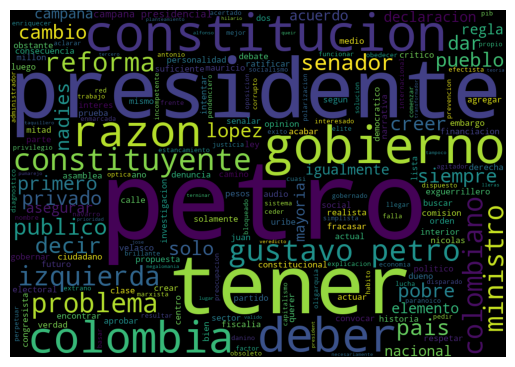

In [66]:

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt


wc = WordCloud(width=1000, height=700).generate_from_frequencies(' '.join(documents))

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.imshow(wc)
plt.axis('off')
plt.show()

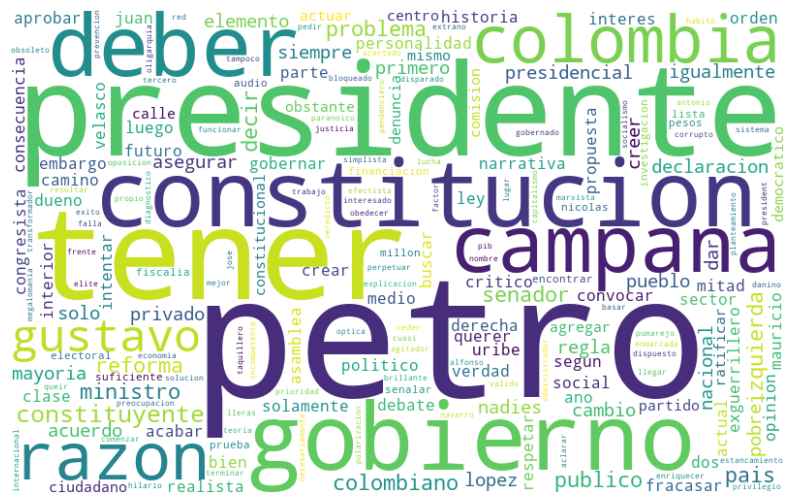

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
